# MEET-EU 2023/2024

### Henri Guilhon, Lorenzo Ballestra, Mathys Delattre, Quentin Despretz

The aim of our project was to train a Graph Convolutional Network on the docking of selected ligands.
To prepare our data, we used Autodock Vina to obtain multiple affinity score of the docking of every ligand on the ATP pocket of the {name of enzyme}.

Our project strongly depend on a dataset wich was given to us :
explain dataset

Every file we used is on the GitHub repository :
- <pre>Data/datasets     : the folder containing the results of our pre-precessed data put into datasets.csv </pre>
- <pre>Data/library      : the folder containing the source dataset with pre-selected potential ligands </pre>
- <pre>Data/train_test   : the folder containing a save of the training and testing sets that were used for the    <pre>                 corresponding models </pre>
- <pre>Models/           : the folder containing a save of every model we trained</pre>
- <pre>GCN.py            : the file countaining the functions related to the Graph Convolutional Network</pre>

The aim of this Notebook is to implement the Graph Convolutional Network that we made on given data.
The data comes from {specifier dataset} 

## 0 - Imports

In [19]:
import pandas as pd
import numpy as np

#Model and useful functions
from GCN import *

#Deep Learning libraries
from torch import nn, optim
from torch_geometric.loader import DataLoader

#Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

#Split data into train and test sets
from sklearn.model_selection import train_test_split

In [6]:
DATASETS_PATH  = "./Data/datasets/"   #the path where the full preprocessed datasets are stored
MODELS_PATH    = "./Models/"            #the path where the models' parameters are stored
TRAINTEST_PATH = "./Data/train_test/"  #the path where the corresponding train and test datasets are stored
LIBRARY_PATH   = "./Data/library/"

## I - Import the data

In [11]:
#The file where we saved the ligands where we predicted 9 conformations (and took the best one)
#NB : We used this file for the training/test of the model and ignored conformations.
file_9 = DATASETS_PATH + "Data_Vina_9.csv"

#The file where we saved the ligands where we predicted 9 conformations (and took the best one)
#NB : We used this file afterwards to assess our model's reliability
file_20 = DATASETS_PATH + "Data_Vina_20.csv"

#Import the data as DataFrames
data_9  = pd.read_csv(file_9)
data_20 = pd.read_csv(file_20)

## II - Import the GCN Model
We have already trained the model, thus we only need to import its parameters.
If you want to train a model we added a section at the end of this notebook
##### II.a) Initiate Model, Loss and Optimizer
Note that each model to import has its own specific parameters, see in the readme for more information. 

In [12]:
nimputs = 4   #number of features per atome, see 'atom_features' function in GCN.py
nlayer1 = 16  #number of weights in each Convolutional layer
nlayer2 = 32  #                "        "
nlayer3 = 8   #                "        "

#Creation of the Model
Model   =  GCN(nimputs,nlayer1,nlayer2,nlayer3)

#Creation of the Loss Function
Loss_fn = nn.MSELoss() #Mean Square Error

##### II.b) Load the trained model's parameters
Models's name format : "model_type_split_batch_hydrogen.pth"

types : 
- 9       : the data came from the datasets where we took the best affinity from 9 docked conformations  
- 20      : the data came from the datasets where we took the best affinity from 20 docked conformations
- catconf : the data came from the dataset where we took into account the "pocket occupation" to choose the conformation docked

split :
- 0.3 : The data were split with a fraction of 0.3 for the test data

batch :
- nobatch : We did not make any batch
- 32: We took a batch size of 32
- 16: We took a batch size of 16

hydrogen :
- addhs : We added hydrogens to the graphs
- noH : We did not add hydrogens to the graphs

In [16]:

MODEL       = "model_9_0.3_nobatch_addhs.pth"   #the model you want to load
ADDHS       = True                                    #if the model has "noH" in its name, then put this to false. 
                                                      #If it has "addhs" put this to True.

Model.load_state_dict(torch.load(MODELS_PATH+MODEL))  #Load the parameters

<All keys matched successfully>

##### II.c) Load the corresponding train and test data

In [17]:
#Recover the train and test dataset we used to evaluate the model properly
data_train = pd.read_csv(TRAINTEST_PATH + MODEL + "_train.csv")
data_test  = pd.read_csv(TRAINTEST_PATH + MODEL + "_test.csv")

## III - Test the model's performance

In [18]:
#Convert the data to a list of graphs, a graph is a torch_geometric.data.Data object
graphs_train = df_to_graphs(data_train, KnownScores=True, addHs = ADDHS)
graphs_test  = df_to_graphs(data_test, KnownScores=True, addHs = ADDHS)

#Fill every graph in a loader
loader_train = DataLoader(graphs_train, batch_size=len(graphs_train), shuffle=False) #Shuffle to false
loader_test  = DataLoader(graphs_test , batch_size=len(graphs_test),  shuffle=False)

#Predict on the train dataset 
with torch.no_grad() :
    for data in loader_train :               # only way to get the loader
        y_pred_train = Model(data).flatten() # make it a vector
        y_val_train  = data.target
        print("Train Mean Squared Error : ", Loss_fn(y_pred_train, y_val_train))
        
#Predict on the test dataset 
with torch.no_grad() :
    for data in loader_test :               
        y_pred_test = Model(data).flatten() 
        y_val_test  = data.target
        print("Test Mean Squared Error  : ", Loss_fn(y_pred_test, y_val_test))


Train Mean Squared Error :  tensor(0.1709)
Test Mean Squared Error  :  tensor(0.1715)


## IV - Check if the best predicted ligands are also the ground truth best 
To do so we tried to sort the affinities scores that we predicted from best to worst. We did the same on the validation data and checked if the molecules were set in the same order. If they are, it would allow to pick the top predicted molecules to find the best possible ligands.

In [36]:
#Same steps on the data_20 dataset
graphs_20 = df_to_graphs(data_20, KnownScores=True, addHs = ADDHS)
loader_20 = DataLoader(graphs_20, batch_size=len(graphs_20), shuffle=False) 

with torch.no_grad() :
    for data in loader_20 :               
        y_pred_20 = Model(data).flatten() 
        y_val_20  = data.target
        print("Mean Squared Error  : ", Loss_fn(y_pred_20, y_val_20))

data_20["pred"] = y_pred_20

Mean Squared Error  :  tensor(0.2081)


Text(0.5, 1.0, 'Relationship between\n predicted and docking affinity')

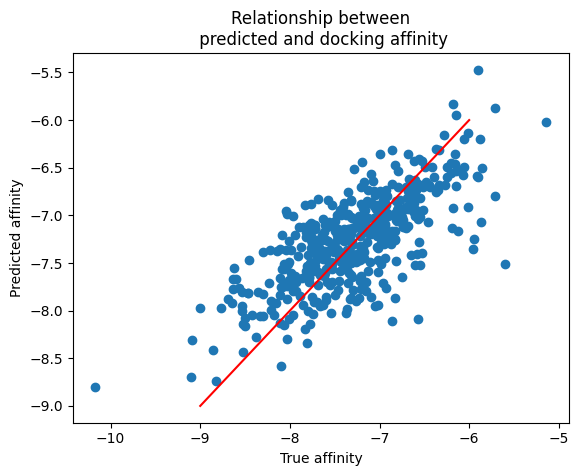

In [27]:
#Plot the relationship between predicted and ground truth affinity on the data_20 dataset
plt.scatter(data_20["Affinity"], data_20["pred"])
plt.plot(np.arange(-9,-5,1), np.arange(-9,-5,1), color='r')
plt.xlabel("True affinity")
plt.ylabel("Predicted affinity")
plt.title("Relationship between\n predicted and docking affinity")

Standard deviation of predicted affinities = 0.48809183
Standard deviation of docking affinities = 0.6595620629649959
Mean of predicted affinities = -7.270136
Mean of docking affinities = -7.303228070175439


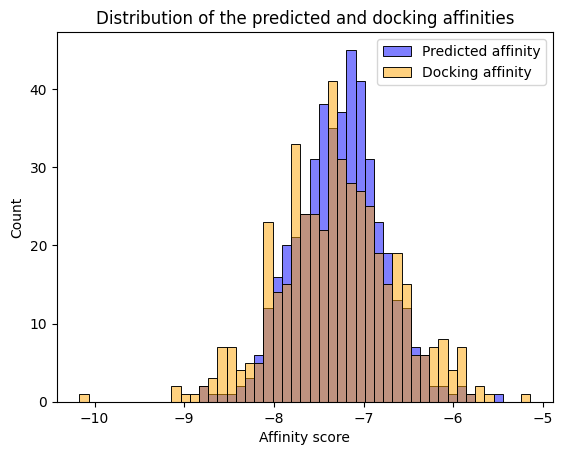

In [29]:
#Plot the relationship distribution of predicted and true affinity on the data_20 dataset
min_value = min(data_20["Affinity"].min(), data_20["pred"].min())
max_value = max(data_20["Affinity"].max(), data_20["pred"].max())
bins = np.linspace(min_value, max_value, 50)

sns.histplot(data_20["pred"], bins=bins, color='blue', alpha=0.5, label="Predicted affinity")
sns.histplot(data_20["Affinity"], bins=bins, color='orange', alpha=0.5, label="Docking affinity")

plt.legend()
plt.ylabel("Count")
plt.xlabel("Affinity score")
plt.title("Distribution of the predicted and docking affinities")

pred_std = data_20["pred"].std()
dock_std = data_20["Affinity"].std()
pred_mean = data_20["pred"].mean()
dock_mean = data_20["Affinity"].mean()

print("Standard deviation of predicted affinities", "=", pred_std)
print("Standard deviation of docking affinities", "=", dock_std)
print("Mean of predicted affinities", "=", pred_mean)
print("Mean of docking affinities", "=", dock_mean)

In [56]:
#Predict the average gap between the predicted and true prosition of the molecule's score 
sorted_pred = data_20.sort_values("pred")
sorted_docked = data_20.sort_values("Affinity")
sorted_pred["indexes"] = np.arange(0, len(sorted_pred))
sorted_docked["indexes"] = np.arange(0, len(sorted_docked))

total_error = 0

for eos in data_20["EOS"]:
    line_pred = sorted_pred[sorted_pred["EOS"]==eos]
    line_dock = sorted_docked[sorted_docked["EOS"]==eos]
    total_error += int(np.abs(line_pred["indexes"].iloc[0]-line_dock["indexes"].iloc[0]))
    
print(total_error/len(sorted_pred))

76.89035087719299


Text(0.5, 1.0, 'Relative error position\nbetween docking and prediction')

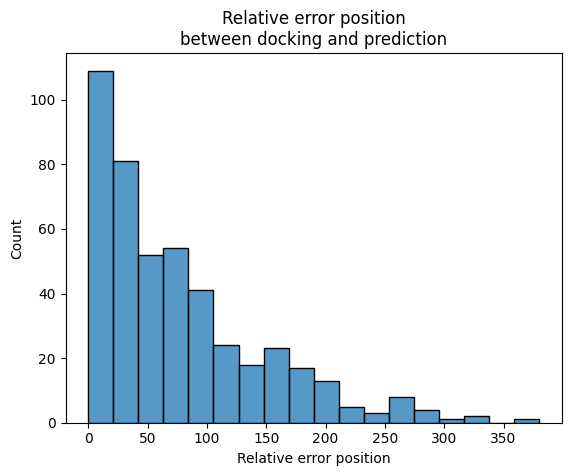

In [57]:
#Try to see if most of the predicted ligands are close to their true place
error = []
line = sorted_pred[sorted_pred["EOS"]==eos]

for eos in data_20["EOS"]:
    line_pred = sorted_pred[sorted_pred["EOS"]==eos]
    line_dock = sorted_docked[sorted_docked["EOS"]==eos]
    error.append(int(np.abs(line_pred["indexes"].iloc[0]-line_dock["indexes"].iloc[0])))
    

sns.histplot(error)
plt.xlabel("Relative error position")
plt.title("Relative error position\nbetween docking and prediction")

## V - Predict the most promising ligands on the source complete dataset
Now we will try our algorithm on all of the data (containing docked and non docked molecules).

In [40]:
# creating dataframe from the pilot library
data_Full = pd.read_csv(LIBRARY_PATH + "pilot_library.csv")
data_Full.rename(columns={'smiles': 'Smile'}, inplace=True)
data_Full.rename(columns={'eos': 'EOS'}, inplace=True)

# creating the list of graphs
graphs_Full = df_to_graphs(data_Full,KnownScores=False, addHs = True) #Turns knownscores to False
loader_Full = DataLoader(graphs_Full, batch_size=len(graphs_Full),  shuffle=False) #important shuffle = false

with torch.no_grad() :
    for data in loader_Full :
        y_pred_Full = Model(data).flatten()

In [46]:
score20 = y_pred_Full.sort()[0][:20]
id20 = y_pred_Full.sort()[1][:20]

eos = data_Full["EOS"].values[id20]

#The predicted promising ligands
print("The promising ligands are : ", eos)

The promising ligands are :  ['EOS101357' 'EOS102307' 'EOS101186' 'EOS100233' 'EOS101072' 'EOS100046'
 'EOS1354' 'EOS101472' 'EOS93' 'EOS1195' 'EOS100814' 'EOS101803' 'EOS1389'
 'EOS100245' 'EOS264' 'EOS100811' 'EOS1824' 'EOS100687' 'EOS101096'
 'EOS98622']


After that we docked those ligands to see if their affinity scores were interesting. We obtained the following results :

In [49]:
#NB : Four ligands were not successfully docked so we only have 16 scores.
VALIDATION = torch.tensor([-9.631, -7.507, -6.559, -8.048, -8.513,-8.083,-9.247,-10.18,-7.56 ,-8.026,-8.78,-7.993,-7.304,-7.708,-8.189,-8.45 ])
print("Validation scores :", VALIDATION)
print(VALIDATION.mean())


Validation scores : tensor([ -9.6310,  -7.5070,  -6.5590,  -8.0480,  -8.5130,  -8.0830,  -9.2470,
        -10.1800,  -7.5600,  -8.0260,  -8.7800,  -7.9930,  -7.3040,  -7.7080,
         -8.1890,  -8.4500])
tensor(-8.2361)


## Bonus - Train the Model


In [50]:
SIZEBATCH = 1000       #Size of one batch in DataLoader, 1000 means no batch
LEARNING_RATE = 0.001  #learning rate
ADDHS = True           #Whether or not to add hydrogens to the molecule

#### B.a) Import the data

In [51]:
#The file where we saved the ligands where we predicted 9 conformations (and took the best one)
file_9 = DATASETS_PATH + "Data_Vina_9.csv"

#Import the data as DataFrames
data_9  = pd.read_csv(file_9)

#We separate our dataset between the trained and non trained data
data_train, data_test = train_test_split(data_9,test_size=0.3 )
data_train = data_train.reset_index(drop=True)
data_test  = data_test.reset_index(drop=True)

#Convert the data to a list of graphs, a graph is a torch_geometric.data.Data object
graphs_train = df_to_graphs(data_train, KnownScores=True, addHs = ADDHS) 
graphs_test  = df_to_graphs(data_test, KnownScores=True, addHs = ADDHS)

#Fill every graph in a loader        NB : Loader impairs speed of learning
loader_train = DataLoader(graphs_train, batch_size=SIZEBATCH, shuffle=True) 
loader_test  = DataLoader(graphs_test , batch_size=len(graphs_test),  shuffle=True) 

#### B.b) Creation of the model

In [52]:
#Creation of the Model
Model   =  GCN(4,16,32,8)

#Creation of the Loss Function
Loss_fn = nn.MSELoss() #Mean Square Error

#Creation of the Optimizer
Optimizer = optim.Adam(Model.parameters(), lr=LEARNING_RATE) 

In [53]:
# If necessary : load a model

#MODEL = "model_9_0.3_nobatch_addHs.pth"  #the model you want to load
#Model.load_state_dict(torch.load(MODELS_PATH+MODEL))

#Be sure to always have the same train and test sets
#data_train = pd.read_csv(TRAINTEST_PATH + MODEL + "_train.csv")
#data_test  = pd.read_csv(TRAINTEST_PATH + MODEL + "_test.csv")

#### B.c) Training the model

In [153]:
epochs = 10000

epoch_count       = []
test_score_count  = []

for epoch in range(epochs): 
    if epoch%1000 == 0 :
        print(epoch)
    epoch_count.append(epoch)
       
    Model.train() #train mode settles all parameters that need gradients (steepness of the hill i.e. pente)
    
    for data in loader_train:
        
        #1: Forward pass
        y_pred = Model(data) #forward, goes through the network
        
        #2: Loss calculation
        loss = Loss_fn(y_pred.flatten(),data.target)
        
        #3: Optimizer zero grad
        Optimizer.zero_grad() #when performing gradient descent, the gradient added is not set to zero
                              #so we need to make it 0 before every iteration
        
        #4: Backward propagation
        loss.backward()
        
        #5: step the optimizer (perform gradient descent)
        Optimizer.step() 
       
    #evaluate the model :
    Model.eval() #turns off unwanted options
     
    if epoch%1 == 0 :
        with torch.no_grad() :
            for testdata in loader_test :
                y_pred_test = Model(testdata)
                test_score_count.append(Loss_fn(y_pred_test.flatten(),testdata.target))
    

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


#### B.d) Visualize the Loss

In [54]:
first = 0 #Starting of the array you want to visualize, permits to zoom on selected regions

plt.plot(test_score_count[first:], color = "orange", label = "Test Score")
plt.legend()

print("test mean", np.array(test_score_count[first:]).mean())

NameError: name 'test_score_count' is not defined

#### B.e) Save the model and the corresponding train/test datasets

In [157]:

MODEL = "model_catconf_0.3_nobatch_addhs.pth"  #model_9or20_testportion_batchsize_Hydrogens.pth

#torch.save(obj=Model.state_dict(), f=MODELS_PATH + MODEL )
#data_train.to_csv(TRAINTEST_PATH + MODEL+'_train.csv', index=False)
#data_test.to_csv(TRAINTEST_PATH + MODEL+'_test.csv', index=False)
